In [1]:
@time versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 96 × Intel(R) Xeon(R) Gold 5318Y CPU @ 2.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, icelake-server)
  Threads: 2 on 96 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia
  0.880317 seconds (639.88 k allocations: 42.994 MiB, 99.29% compilation time)


# Test a custom Jupyter Kernel with a pre-built sysimage.

Pairplots pre-compilation used to be very slow (could be as long as minutes).

```bash
huangyu@n100:~$ cat .local/share/jupyter/kernels/julia-1.9-PairPlots-Turing/kernel.json 
{
  "display_name": "Julia 1.9.3 w PairPlots & Turing",
  "argv": [
    "/y/home/huangyu/packages/julias/julia-1.9/bin/julia",
    "-i",
    "-J", "/y/home/huangyu/.julia/sysimage/PairPlots_Turing_sysimage.so",
    "--color=yes",
    "/y/home/huangyu/.julia/packages/IJulia/Vo51o/src/kernel.jl",
    "{connection_file}"
  ],
  "language": "julia",
  "env": {},
  "interrupt_mode": "signal"
}

```

The sysimage is built by 

```julia
julia> using PackageCompiler

(@v1.9) pkg> add PairPlots Turing CairoMakie

(@v1.9) pkg> activate .
Activating environment at `~/.julia/sysimage/Project.toml`

(sysimage) pkg> statusStatus `~/.julia/sysimage/Project.toml`
  [13f3f980] CairoMakie v0.10.11
  [43a3c2be] PairPlots v1.1.1
  [fce5fe82] Turing v0.29.3
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.

julia> create_sysimage(["PairPlots", "Turing", "CairoMakie", "DataFrames", "CSV"]; sysimage_path="PairPlots_Turing_sysimage.so")
```


# Loading CairoMakie and PairPlots took 17 seconds without sysimage.
With sysimage, it took 0.009 seconds.

In [2]:
@time using CairoMakie, PairPlots
@time using DataFrames, CSV

  0.009260 seconds (10.07 k allocations: 661.186 KiB)
  0.000315 seconds (271 allocations: 25.852 KiB)


In [3]:
@time d = DataFrame(CSV.File(expanduser("~/src/rethinking-2ed-julia/data/WaffleDivorce.csv")))

  1.704446 seconds (1.04 M allocations: 69.104 MiB, 1.75% gc time, 99.62% compilation time: 53% of which was recompilation)


Row,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,String31,String3,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.0
7,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.0
8,Delaware,DE,0.9,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016
9,District of Columbia,DC,0.6,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.0


# 1. The first pairplot() attempt took 10.9 or 16.2 seconds.

  9.958083 seconds (12.45 M allocations: 807.939 MiB, 4.00% gc time, 96.48% compilation time: 5% of which was recompilation)


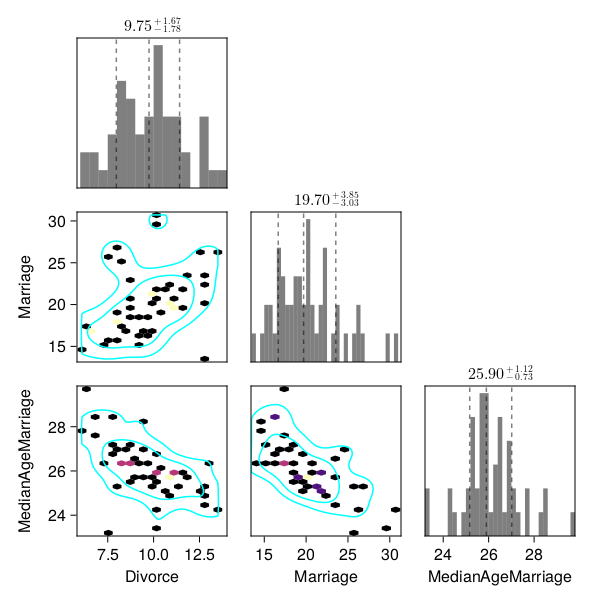

In [4]:
@time pairplot(
    d[!, [:Divorce, :Marriage, :MedianAgeMarriage]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

# 2. The 2nd pairplot() attempt took 0.313 seconds.

  0.271450 seconds (400.64 k allocations: 53.940 MiB, 8.43% gc time, 3.98% compilation time)


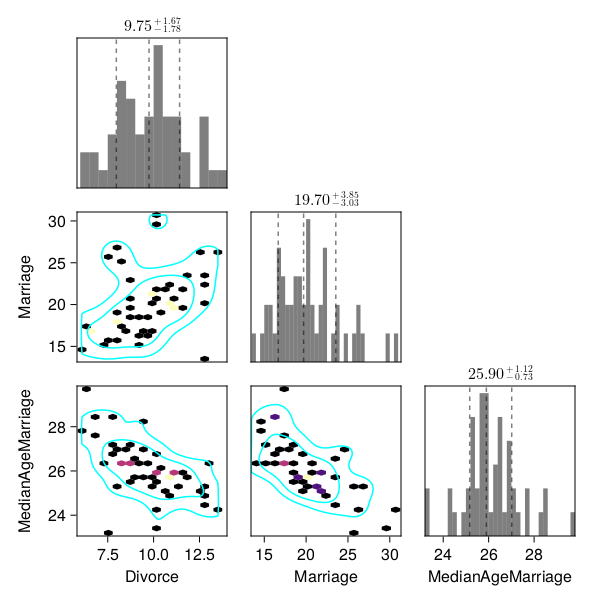

In [5]:
@time pairplot(
    d[!, [:Divorce, :Marriage, :MedianAgeMarriage]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)